Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

import time

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

Loading the dataset with Amazon, Yelp, and IBDB reviews.

In [2]:
amazon = pd.read_csv('amazon_cells_labelled.txt', sep="\t", header=None)
amazon.columns = ["message", "rating"]
yelp = pd.read_csv('yelp_labelled.txt', sep="\t", header=None)
yelp.columns = ["message", "rating"]
imdb = pd.read_csv('imdb_labelled.txt', sep="\t", header=None)
imdb.columns = ["message", "rating"]
datalist = [amazon, yelp, imdb]
data = pd.concat(datalist)

In [3]:
# Change the indexes of the concated dataframe to the lenth of the dataframe. 
data.index = range(len(data))

In [4]:
# Separate the positive and negative reviews
negative = data[data['rating'] == 0]
positive = data[data['rating'] == 1]

In [5]:
# Dictionary with the frequency of words in negative reviews. 
neg_dictionary = {}
for sentence in negative['message']:
    for word in sentence.strip('!,."').split():
        if word.lower() in neg_dictionary:
            neg_dictionary[word.lower()] += 1.0
        else:
            neg_dictionary[word.lower()]  = 1.0

In [6]:
# Dictionary with the frequency of words in positive reviews. 
pos_dictionary = {}
for sentence in positive['message']:
    for word in sentence.strip('!,."').split():
        if word.lower() in pos_dictionary:
            pos_dictionary[word.lower()] += 1.0
        else:
            pos_dictionary[word.lower()]  = 1.0

In [7]:
# Create an empty column filled with 0's for each word that has greater than 50 occurances in the positive reviews
for key in pos_dictionary:
    if pos_dictionary[key] > 50:
        data[key] = [0] * len(data)

In [8]:
# Create an empty column filled with 0's for each word that has greater than 50 occurances in the negative reviews
for key in neg_dictionary:
    if neg_dictionary[key] > 50:
        data[key] = [0] * len(data)

In [9]:
data

,message,rating,good,great,for,the,is,you,are,have,...,at,would,your,only,we,bad,don't,just,1,0
0,So there is no way for me to plug it in here i...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Good case, Excellent value.",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Great for the jawbone.,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tied to charger for conversations lasting more...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The mic is great.,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,I have to jiggle the plug to get it to line up...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,If you have several dozen or several hundred c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,If you are Razr owner...you must have this!,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Needless to say, I wasted my money.",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,What a waste of money and time!.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# list of the dataframe's column names
columns_names = list(data)

In [11]:
# For each row in the dataframe
for i, sentence in data.iterrows():
    # For each message in the review, strip the markings, and split it into each word.
    for word in sentence['message'].strip('!,."').split():
        # Iterate through each column name in the dataframe
        for name in columns_names:
            # If a column name and word are the same. 
            if word.lower() == name:
                # Add up the frequency of that word in that message
                data.loc[ i, word.lower() ] += 1

In [12]:
data

,message,rating,good,great,for,the,is,you,are,have,...,at,would,your,only,we,bad,don't,just,1,0
0,So there is no way for me to plug it in here i...,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Good case, Excellent value.",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Great for the jawbone.,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tied to charger for conversations lasting more...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The mic is great.,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,I have to jiggle the plug to get it to line up...,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,If you have several dozen or several hundred c...,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7,If you are Razr owner...you must have this!,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,"Needless to say, I wasted my money.",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,What a waste of money and time!.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


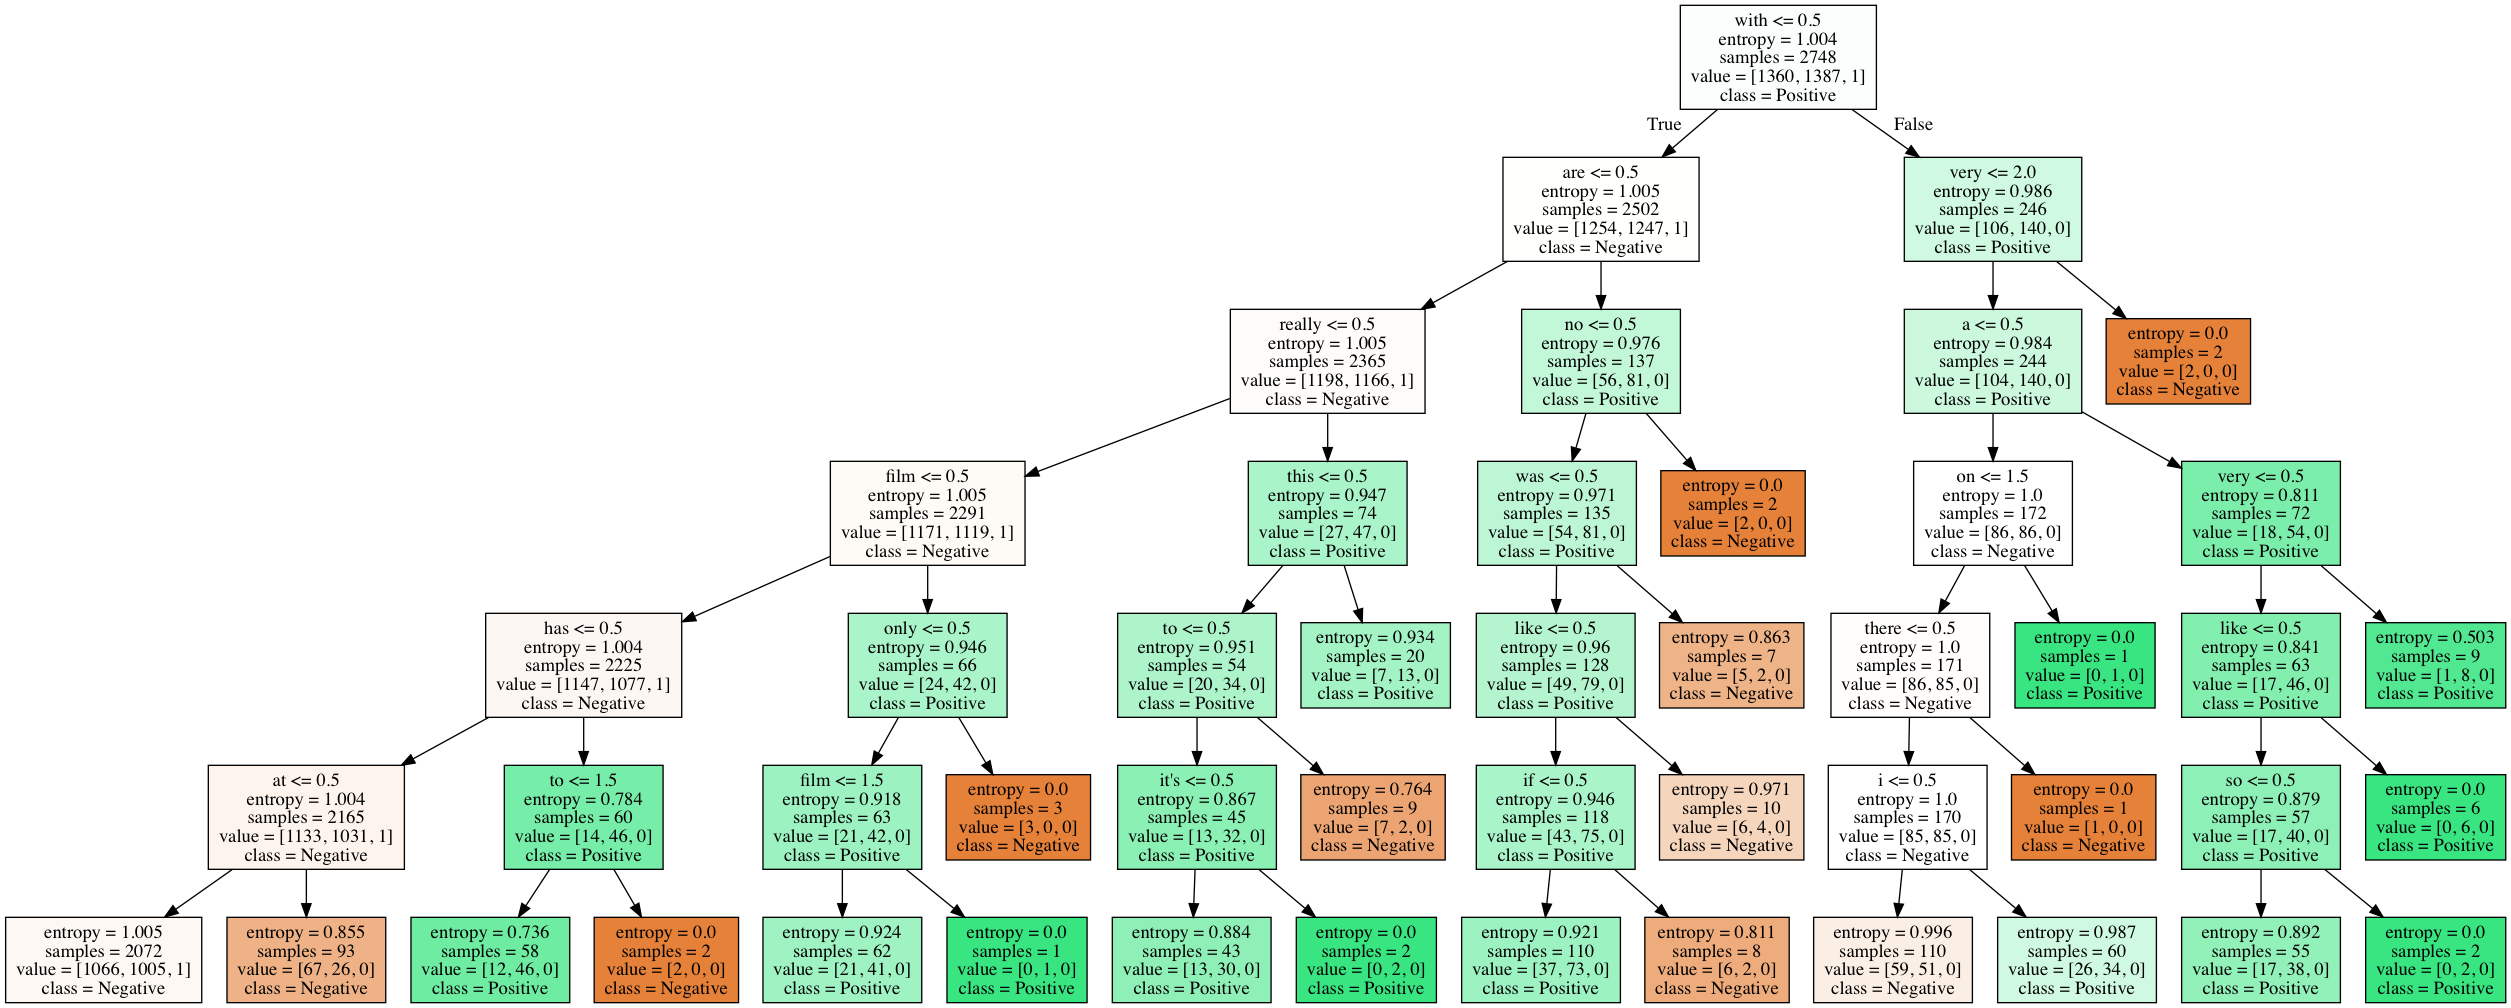

In [13]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=30,
    max_features=2,
    max_depth=6
)
features = data.drop(['message', 'rating'], axis=1, inplace=False)
decision_tree.fit(features, data['rating'])

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=features.columns,
    class_names=['Negative', 'Positive'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

In [14]:
start_time = time.time()
score = cross_val_score(decision_tree, features, data['rating'], cv=5)
print('\nEach Decision Tree Cross Validated R2 score: \n', score)
print("\n---Decision Tree took %s seconds ---\n" % (time.time() - start_time))


Each Decision Tree Cross Validated R2 score: 
 [ 0.59346642  0.50181818  0.57377049  0.5136612   0.51730419]

---Decision Tree took 0.12525105476379395 seconds ---



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [15]:
start_time = time.time()
rfc = ensemble.RandomForestClassifier()
Random_R2 = cross_val_score(rfc, features, data['rating'], cv=5)
print('\nEach Random Forest Cross Validated R2 score: \n', Random_R2)
print("\n---Random Forest took %s seconds ---\n" % (time.time() - start_time))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)



Each Random Forest Cross Validated R2 score: 
 [ 0.68602541  0.65090909  0.62659381  0.61202186  0.56284153]

---Random Forest took 0.33799028396606445 seconds ---

